Markov-Switching Model (MSM) 

<!-- is a statistical Markov model in which the system being modeled is assumed to be a Markov process with unobserved (i.e. hidden) states. Observed data is our market features, hidden states are our market behavior.


It is simple enough. But also its rich enough. 

We can use it as a baseline model. 

https://www.youtube.com/watch?v=TPRoLreU9lA -->

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from datetime import datetime
from io import BytesIO
from dateutil.relativedelta import relativedelta
import quandl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
import seaborn as sns
import joblib

import yfinance as yf
import plotly.express as px

In [2]:
data_df = pd.read_pickle('/data/workspace_files/data_df92.pickle')
rf_df = pd.read_pickle('/data/workspace_files/data_rf.pickle')

In [3]:
data_df = pd.merge_asof(data_df, rf_df, right_index=True, left_index=True)

In [4]:
# Split the data on sets
train_set = data_df.iloc[data_df.index < pd.to_datetime('2018-01-01 00:00:00')]
test_set = data_df.iloc[data_df.index >= pd.to_datetime('2017-12-22 00:00:00')]
train_ind = list(data_df.index).index(test_set.index[0]) + 1
print("train set size is ", train_set.shape[0], ", test set size is ", test_set.shape[0])

train set size is  1351 , test set size is  211


In [5]:
basepath = '/data/workspace_files/'

filename = 'Equity_Risk_Premium.csv'
df_ER = pd.read_csv(basepath+filename)
df_ER.index = pd.to_datetime(df_ER['date'])
df_ER = df_ER.drop(columns={'date'})
df_ER['Real_Bond_Yield'] = pd.to_numeric(df_ER['Real_Bond_Yield'])

filename = 'Avg_Investor_Holding.csv'
df_IH = pd.read_csv(basepath+filename)
df_IH.set_index('date', inplace=True)
df_IH.index = pd.to_datetime(df_IH.index)

# Model 

In [12]:
mod_hamilton = sm.tsa.MarkovAutoregression(
    train_set.future_return, 
    k_regimes = 3,
    order = 1, switching_ar=True, 
    exog_tvtp=train_set.VIX, #switching_exog=True,
    # trend='ct',
    # switching_trend=True,
    switching_variance=True
)
mod_hamilton_prediciton = sm.tsa.MarkovAutoregression(
    test_set.future_return, 
    k_regimes = 3,
    order = 1, switching_ar=True,
    exog_tvtp=test_set.VIX, #switching_exog=True,
    switching_variance=True
)
res_hamilton = mod_hamilton.fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
res_hamilton.summary()

Markov Switching Model Results 
 
 Dep. Variable: future_return No. Observations: 1350 
 
 
 Model: MarkovAutoregression Log Likelihood 3326.924 
 
 
 Date: Mon, 28 Feb 2022 AIC -6623.847 
 
 
 Time: 21:25:18 BIC -6545.729 
 
 
 Sample: 02-10-1992 HQIC -6594.592 
 
 
 - 12-25-2017 
 
 
 Covariance Type: approx 
 
 
 
 Regime 0 parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 const 0.0081 0.002 3.931 0.000 0.004 0.012 
 
 
 sigma2 0.0001 3.8e-05 3.155 0.002 4.54e-05 0.000 
 
 
 ar.L1 -0.3644 0.058 -6.327 0.000 -0.477 -0.252 
 
 
 
 Regime 1 parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 const -0.0016 0.002 -0.744 0.457 -0.006 0.003 
 
 
 sigma2 0.0002 2.45e-05 6.956 0.000 0.000 0.000 
 
 
 ar.L1 0.2908 0.058 4.987 0.000 0.177 0.405 
 
 
 
 Regime 2 parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 const -0.0036 0.002 -1.913 0.056 -0.007 8.76e-05 
 
 
 sigma2 0.0011 8.4e-05 12.836 0.000 0.001 0.001 
 
 
 ar.L1 -0.2202 0.083 -2.660 0.008 -0.382 -0.058 
 
 
 
 Regime transition parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 p[0->0].tvtp0 5.4753 6.706 0.817 0.414 -7.668 18.618 
 
 
 p[1->0].tvtp0 4.1330 4.143 0.998 0.319 -3.988 12.254 
 
 
 p[2->0].tvtp0 -3.7992 2.248 -1.690 0.091 -8.204 0.606 
 
 
 p[0->1].tvtp0 -5.2966 3.785 -1.399 0.162 -12.716 2.122 
 
 
 p[1->1].tvtp0 -3.5863 5.994 -0.598 0.550 -15.334 8.161 
 
 
 p[2->1].tvtp0 -6.1725 2.299 -2.685 0.007 -10.677 -1.667 
 
 Warnings: [1] Covariance matrix calculated using numerical (complex-step) differentiation.

In [14]:
res_hamilton.params

In [15]:
mod_hamilton.predict_conditional(res_hamilton.params)[:,:,0]

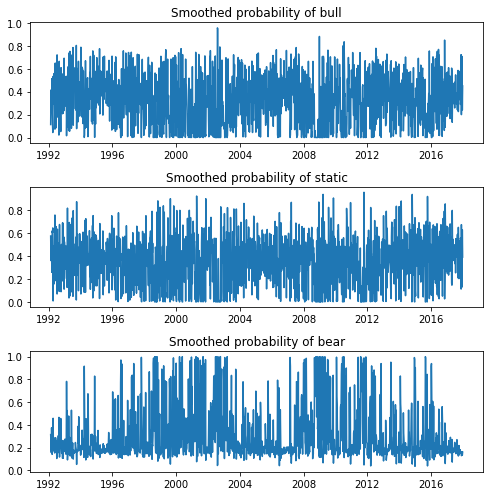

In [16]:
fig, axes = plt.subplots(3, figsize=(7, 7))

ax = axes[0]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of bull")

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of static")

ax = axes[2]
ax.plot(res_hamilton.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of bear")

fig.tight_layout()

In [17]:
res_hamilton.smoothed_marginal_probabilities.idxmax(axis=1).value_counts()

In [18]:
def plot_hidden_states(res_hamilton, data, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(3, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, 3))
    hidden_states = res_hamilton.smoothed_marginal_probabilities.idxmax(axis=1)
    print(hidden_states.value_counts())
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()

1    578
0    479
2    293
dtype: int64


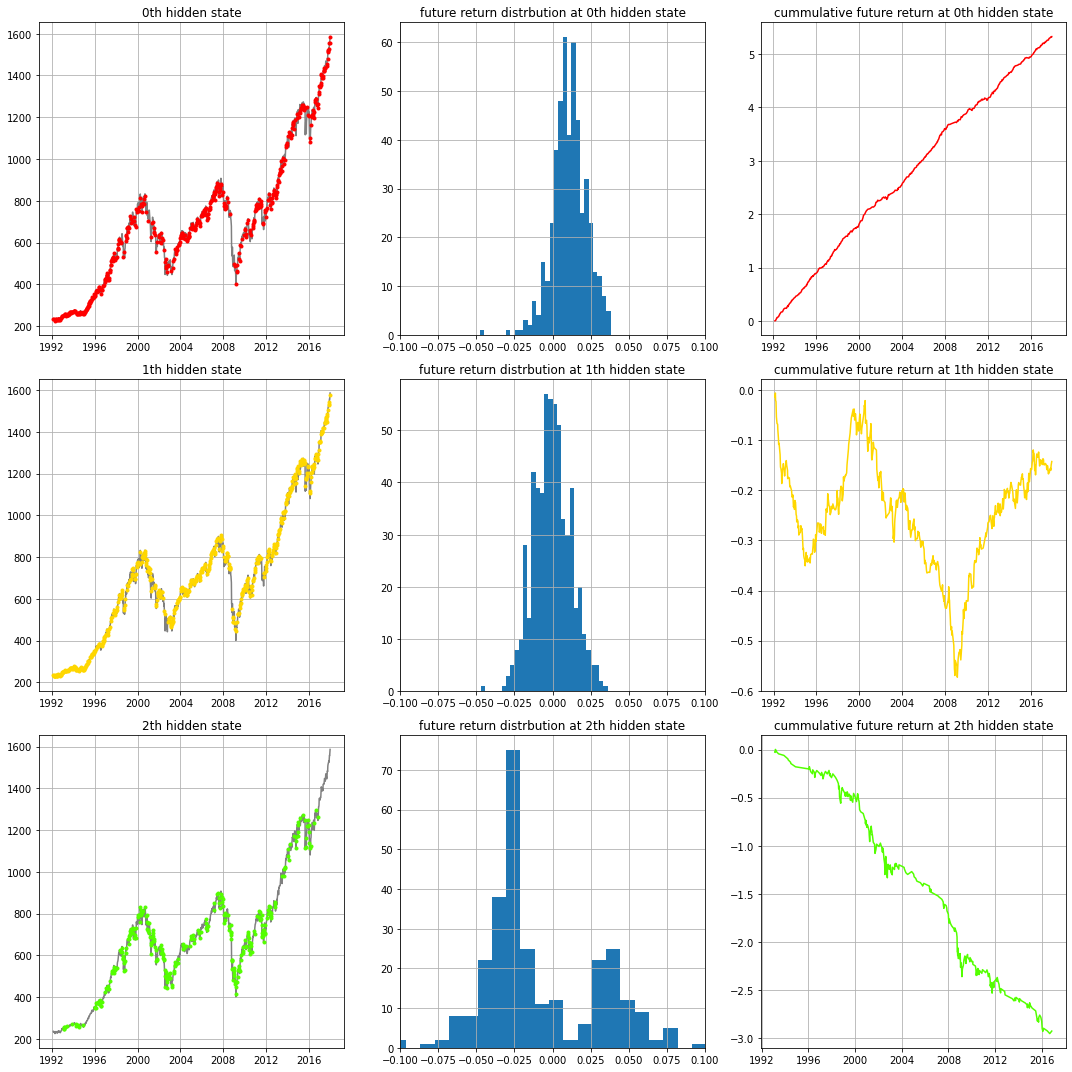

In [19]:
plot_hidden_states(res_hamilton, data_df[:train_ind][1:], 'Close')

In [20]:
states_map = {"bear": 2,
              "bull": 0,
              "static": 1}

signal_map = {v: k for k, v in states_map.items()}

In [21]:
def state_predictor(params, model):
    conditional_prediciton = model.predict(params=params, conditional=True).T
    model_prediction = model.predict(params=params)
    s = np.abs(conditional_prediciton.T - [model_prediction] * 3)
    return s.argmin(axis=0)

test_set_res = test_set.copy()[1:]
test_set_res['signal'] = state_predictor(res_hamilton.params, mod_hamilton_prediciton)
test_set_res.signal.value_counts()

In [22]:
train_set.drop(columns=['VIX'], inplace=True)
vix_df = pd.read_pickle('/data/workspace_files/data_vix.pickle') 
train_set = pd.merge_asof(train_set, vix_df / 100, right_index=True, left_index=True)
test_set_res.drop(columns=['VIX'], inplace=True)
test_set_res = pd.merge_asof(test_set_res, vix_df / 100, right_index=True, left_index=True)

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
train_set_res = pd.merge_asof(train_set.copy()[1:], df_ER[['Equity Risk Premium']], left_index=True, right_index=True)
train_set_res = pd.merge_asof(train_set_res, df_IH[['Avg. Stock Holding']], left_index=True, right_index=True)
train_set_res['signal'] = np.array(res_hamilton.smoothed_marginal_probabilities).argmax(axis=1)

In [24]:
risk_aversion = dict()
risk_premium = dict()
for regime in ['bull', 'bear', 'static']:
    risk_aversion[regime] = 3 / train_set_res.VIX.mean() * train_set_res[train_set_res.signal==states_map[regime]].VIX.mean()
    # risk_aversion[regime] = 1 / train_set_res[train_set_res.signal==states_map[regime]]['Avg. Stock Holding'].mean()
    # risk_premium[regime] = train_set_res[train_set_res.signal==states_map[regime]]['Equity Risk Premium'].mean() - train_set_res[train_set_res.signal==states_map[regime]].RF.mean()
    risk_premium[regime] = train_set_res[train_set_res.signal==states_map[regime]]['future_return'].mean() * 52 - train_set_res[train_set_res.signal==states_map[regime]].RF.mean()

In [25]:
(risk_aversion, risk_premium)

({'bull': 2.835931188138735,
  'bear': 3.7231633660694152,
  'static': 2.769380786545341},
 {'bull': 0.5504972425280706,
  'bear': -0.5455112454439829,
  'static': -0.038761033165902264})

In [26]:
def mean_variance_weight(vol, signal):
    variance = vol**2
    weight= np.divide((1/risk_aversion[signal_map[signal]]) * (risk_premium[signal_map[signal]]), variance)
    return weight

In [31]:
test_set_res['weight'] = [mean_variance_weight(vol, int(signal)) for i, (vol, signal) in test_set_res[['VIX','signal']].iterrows()]

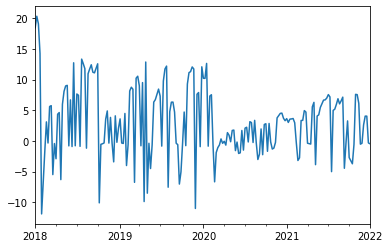

In [32]:
test_set_res['weight'].plot()

In [33]:
test_set_res['weight'] = np.minimum(np.maximum(test_set_res['weight'], -1),1)

In [34]:
initial_capital = 100 
test_set_res['strategy_1'] = 0.
test_set_res['strategy_2'] = 0.
test_set_res['strategy_1'].iloc[0] = initial_capital
test_set_res['strategy_2'].iloc[0] = initial_capital

v_t = initial_capital
### Strategy 1
for i in range(test_set_res.shape[0]-1):
    if test_set_res['signal'].iloc[i] == states_map['bull']:
        v_t = v_t * (1 + test_set_res['future_return'].iloc[i])
    if test_set_res['signal'].iloc[i] == states_map['bear']:
        v_t = v_t * (1 - test_set_res['future_return'].iloc[i])
    test_set_res['strategy_1'].iloc[i+1] = v_t

v_t = initial_capital
### Strategy 2
for i in range(test_set_res.shape[0]-1):
    v_t = v_t * (1 + test_set_res['future_return'].iloc[i] * test_set_res['weight'].iloc[i])
    test_set_res['strategy_2'].iloc[i+1] = v_t

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [35]:
test_set_res['benchmark'] = 100 * (test_set_res['future_return'] + 1).cumprod()

In [36]:
px.line(test_set_res[['strategy_1', 'strategy_2', 'benchmark']])

Unsupported

In [37]:
# test_set_new = pd.concat([train_set_res, spy_vix_data[['VIX','RF']].resample('W').last()],axis=1).dropna()

test_set_new = test_set_res.copy()

In [38]:
columns = ['strategy_1','strategy_2','benchmark']

df_summary = pd.DataFrame()
final = {}

for column in columns:
    df_returns = test_set_new[column].pct_change()
    s = {}

    yearly_multiplier = 52 #weekly
    year_count = relativedelta(test_set_new['RF'].index[-1], test_set_new['RF'].index[0]).years
    rf = (1 + test_set_new['RF'] / yearly_multiplier).prod() ** (1 / year_count) - 1
    s['Mean Return'] = np.exp(np.log(test_set_new[column]/test_set_new[column].shift(1)).mean() * yearly_multiplier) - 1
    s['Volatility'] = df_returns.std() * np.sqrt(yearly_multiplier)
    s['Skewness'] = df_returns.skew()
    s['Kurtosis'] = df_returns.kurtosis()
    s['Maximum Drawdown'] = (test_set_new[column] / test_set_new[column].cummax()-1).min()
    s['Sharpe Ratio'] = (s['Mean Return'] - rf) / s['Volatility']
    s['Semi-Deviation'] = df_returns[df_returns < df_returns.mean()].std()*np.sqrt(yearly_multiplier)
    s['1-month Autocorrelation'] = df_returns.autocorr(lag=1)
    s['3-month Autocorrelation'] = df_returns.autocorr(lag=3)
    s['1-year Autocorrelation'] = df_returns.autocorr(lag=12)
    s
    final[column] = s

df_summary = pd.DataFrame.from_dict(final, orient='index').round(4).T
# df_summary.to_csv('res.csv')
df_summary

,strategy_1,strategy_2,benchmark
Mean Return,0.3424,0.3638,0.1577
Volatility,0.1419,0.1279,0.1580
Skewness,0.7865,0.1645,-1.3324
Kurtosis,10.4336,4.0967,7.5491
Maximum Drawdown,-0.1962,-0.1343,-0.2860
Sharpe Ratio,2.3326,2.7552,0.9257
Semi-Deviation,0.1034,0.0940,0.1393
1-month Autocorrelation,0.0471,0.0440,0.1642
3-month Autocorrelation,0.0945,0.0444,-0.0511
1-year Autocorrelation,-0.0601,-0.0610,-0.0287


In [39]:
## writing output of models
rename_map = {
        'bull' : 1,
        'bear' : -1,
        'static' : 0
    }
replace_map = {v : rename_map[k] for k, v in states_map.items()}
train_set_res.signal.replace(replace_map, inplace=True)
test_set_res.signal.replace(replace_map, inplace=True)

train_set_res[['signal']].to_pickle('/data/workspace_files/output/MSM_train.pickle')
test_set_res[['signal']].to_pickle('/data/workspace_files/output/MSM_test.pickle')